## CTD Transect Report, Lake Zug, 12.01.2026

In [1]:
# imports
import ewgreaders as ewg
import pylake
import os
from glob import glob
import json
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import datetime
import warnings; warnings.filterwarnings('ignore')
#%matplotlib qt
%matplotlib inline

c:\Users\herremha\AppData\Local\anaconda3\envs\ewg\Lib\site-packages\pylake\pylake.py:3: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
serial_id = '1807'
lake = 'Zugersee'
year = '2026'
date = '20260112'

dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

#### Lake map

Profiles overlayed on bathymetry and transect depths.

In [7]:
def extract_profile_locations(dpath_L1, oom=True):
    profile_locs = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # Swiss coordinates
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)

        # bathymetry
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()
        
        profile_locs.append({
            'name': ds.attrs['Profile name'],
            'xsc': xsc,
            'ysc': ysc,
            'total_depth': total_depth
        })

    return pd.DataFrame(profile_locs).sort_values('ysc', ascending=False).reset_index(drop=True), bathy

In [8]:
profile_locs, bathy = extract_profile_locations(dpath_L1)

In [9]:
def plot_profiles_map_bathy(profile_locs, bathy):
    # don't doule plot duplicates
    profile_locs = profile_locs.drop_duplicates(subset='name')

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), width_ratios=[1.2, 1])

    # map
    im = ax[0].pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Greys_r', vmin=0)
    cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', location='left', pad=0.13, ax=ax[0])
    cbar.ax.invert_yaxis()

    # bathymetry
    sns.lineplot(profile_locs, x='ysc', y='total_depth', marker='o', ax=ax[1])
    
    # profile locations
    for _, p in profile_locs.iterrows():
        ax[0].scatter(p['xsc'], p['ysc'], c='steelblue', edgecolor='black', marker='o')
        ax[0].annotate(p['name'], (p['xsc'], p['ysc']), color='red', xytext=(3,0), textcoords='offset points')
        ax[1].annotate(p['name'], (p['ysc'], p['total_depth']), color='red', xytext=(0,5), textcoords='offset points')
        

    ax[1].set_xlabel('Y Swiss Coordinate')
    ax[1].set_ylabel('Depth [m]')

    ax[1].set_ylim(0, 205)
    ax[1].invert_xaxis()
    ax[1].invert_yaxis()
    ax[1].grid()
    ax[1].spines[['right', 'top']].set_visible(False)

    plt.tight_layout(w_pad=2)
    plt.show()

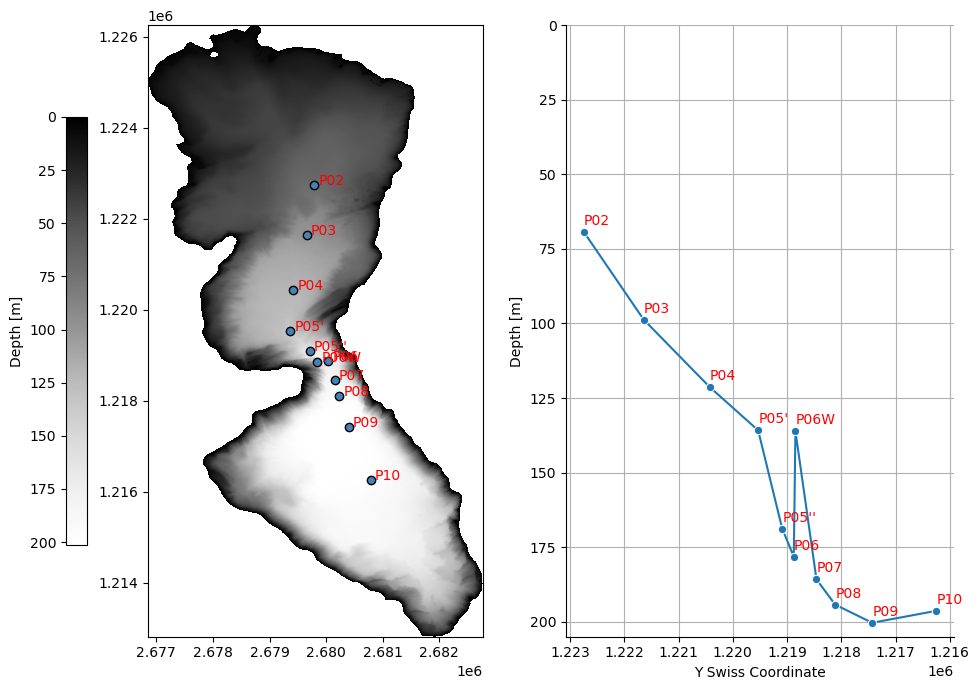

In [10]:
plot_profiles_map_bathy(profile_locs, bathy)

#### Fall speed

L1 .nc files only have minute precision for time, can't calculate fall speed.

#### Temperature/Oxygen transect

In [13]:
def extract_data_vars(dpath_L1, var, oom=True):
    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        mask = (ds['depth'].notnull()) & (ds[f'{var}_qual'] == 0)
        depth = ds['depth'][mask]
        vals = ds[var][mask]

        dat = pd.DataFrame({
            'depth': depth,
            var : vals
        })
        dat[['name', 'time', 'xsc', 'ysc', 'total_depth']] = name, time, xsc, ysc, total_depth
        data.append(dat)

    return pd.concat(data, ignore_index=True).sort_values(by=['time', 'depth'], ascending=True).reset_index(drop=True)

In [14]:
temp_data = extract_data_vars(dpath_L1, 'Temp')
do_data = extract_data_vars(dpath_L1, 'DO_mg')

In [15]:
def plot_profiles_transect(data, var, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]
    
    fig, ax = plt.subplots(nrows=1, ncols=len(df['time'].unique()), figsize=(15, 5), sharex=True, sharey=True)
    if var == 'Temp':
        color = 'steelblue'
    elif var == 'DO_mg':
        color = 'green'

    for i, (t, dat) in enumerate(df.groupby('time', sort=False)):
        ax[i].plot(dat[var], dat['depth'], color=color)
        ax[i].axhline(dat['total_depth'].unique()[0], color='gray', ls='--')

        ax[i].set_title(dat['name'].unique()[0])
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[i].grid(True)

    ax[0].set_ylabel('Depth [m]')
    ax[0].invert_yaxis()

    if var == 'Temp':
        fig.supxlabel('Temperature [°C]')
    elif var == 'DO_mg':
        fig.supxlabel('Dissolved Oxygen Concentration [mg/L]')

    plt.tight_layout(w_pad=0.5)
    plt.show()

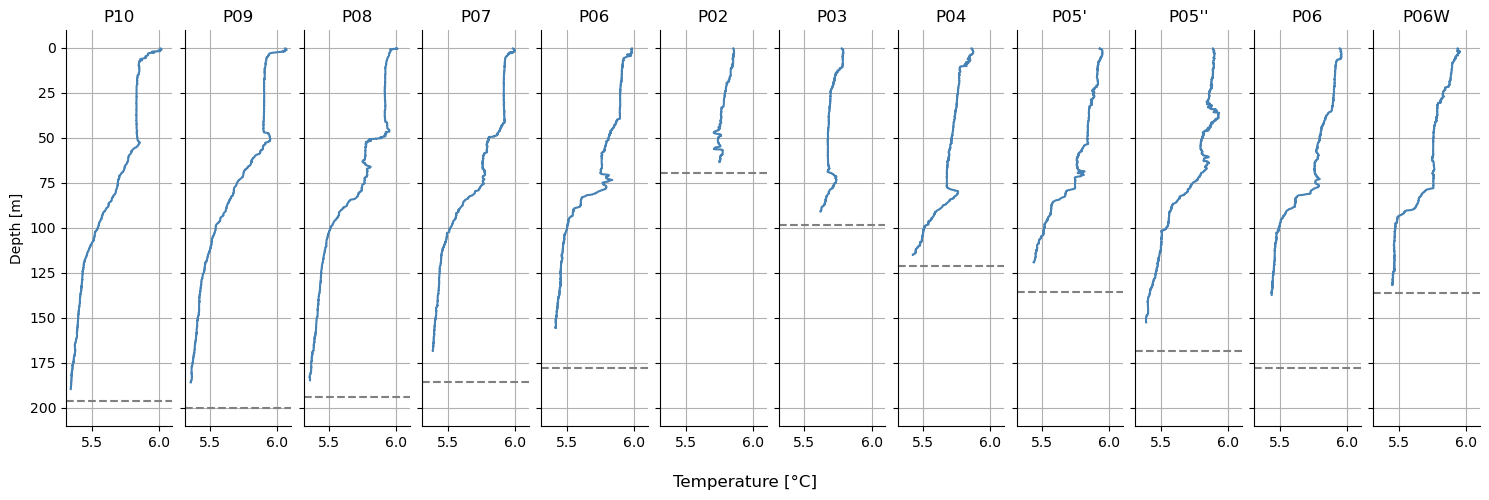

In [16]:
plot_profiles_transect(temp_data, 'Temp')

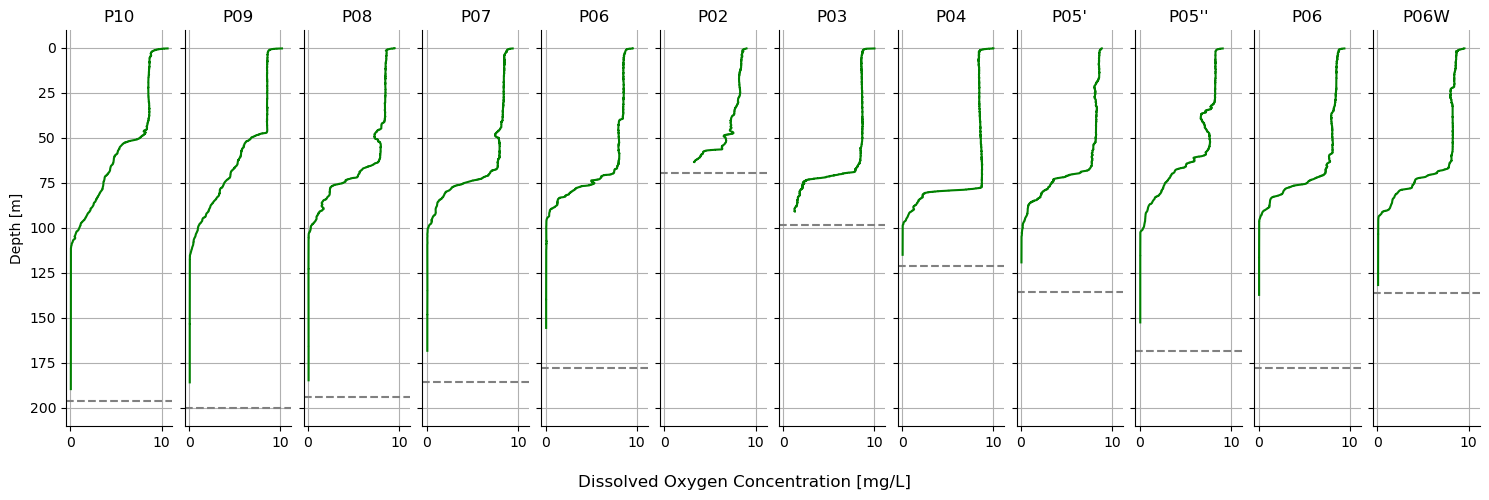

In [17]:
plot_profiles_transect(do_data, 'DO_mg')

#### Temperature/Oxygen repeated location

In [18]:
def plot_profiles_overlay(data, var, locs):
    df = data[data['name'].isin(locs)]

    fig, ax = plt.subplots(figsize=(7, 5))

    for t, dat in df.groupby('time', sort=False):
        ax.plot(dat[var], dat['depth'], label=f"{dat['name'].unique()[0]} | {t}")

    if var == 'Temp':
        ax.set_xlabel('Temperature [°C]')
    elif var == 'DO_mg':
        ax.set_xlabel('Dissolved Oxygen Concentration [mg/L]')
    ax.set_ylabel('Depth [m]')
    ax.set_title(f'Profile Locations {locs}')

    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True)
    ax.legend()
    ax.invert_yaxis()

    plt.show()

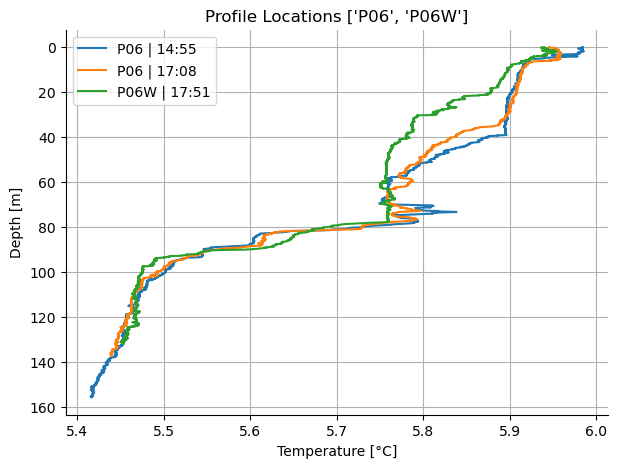

In [23]:
plot_profiles_overlay(temp_data, 'Temp', ["P06", "P06W"])

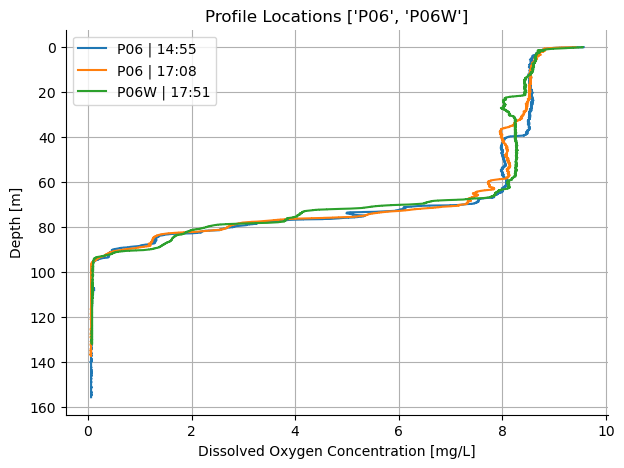

In [24]:
plot_profiles_overlay(do_data, 'DO_mg', ["P06", "P06W"])

#### Isotherms/Isopycnals

In [28]:
def calculate_isolines(dpath_L1, var, isovals, oom=True):
    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        if var == 'Temp':
            mask = (ds['depth'].notnull()) & (ds[f'{var}_qual'] == 0)
        elif var == 'rho':
            mask = (ds['depth'].notnull()) & (ds['Temp_qual'] == 0) & (ds['Cond_qual'] == 0)
        depth = ds['depth'][mask]
        vals = ds[var][mask] 

        for iv in isovals:
            try:
                if var == 'Temp':
                    idxl = np.where(vals < iv)[0][0]
                    idxu = np.where(vals > iv)[0][-1]
                elif var == 'rho':
                    idxl = np.where(vals > iv)[0][0]
                    idxu = np.where(vals < iv)[0][-1]

                idx = round((idxl + idxu)/2)
                z = depth[idx].item()
            except IndexError:
                z = np.nan

            data.append({
                'var': var,
                'iso_val': iv,
                'iso_z': z,
                'name': name,
                'time': time,
                'xsc': xsc,
                'ysc': ysc,
                'total_depth': total_depth
            })

    return pd.DataFrame(data).sort_values(by='time', ascending=True).reset_index(drop=True)

In [29]:
isotherm_data = calculate_isolines(dpath_L1, 'Temp', [6.0, 5.9, 5.8, 5.7, 5.6, 5.5, 5.4])
isopycnal_data = calculate_isolines(dpath_L1, 'rho', np.array([0.13, 0.14, 0.15, 0.16, 0.17]) + 1000)

In [30]:
def plot_isolines(data, var, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]

    fig, ax = plt.subplots(figsize=(7, 5))
    order = np.sort(df['iso_val'].unique())
    if var == 'Temp':
        palette = sns.color_palette('Blues_d', n_colors=len(order))[::-1]
    elif var == 'rho':
        palette = sns.color_palette('Oranges_d', n_colors=len(order))

    sns.lineplot(df, x='ysc', y='iso_z', hue='iso_val', hue_order=order, palette=palette, marker='o', ax=ax)

    md = df.groupby(['name', 'time', 'xsc', 'ysc'])['total_depth'].mean().reset_index()
    sns.lineplot(md, x='ysc', y='total_depth', color='gray', ls='--', ax=ax)

    ax.set_xlabel('Y Swiss Coordinate')
    ax.set_ylabel('Depth [m]')
    ax.set_xticks(md['ysc'], labels=md['name'], rotation=90)
    ax.set_ylim(0, 205)

    if var == 'Temp':
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], title='Temperature [°C]')
    elif var == 'rho':
        ax.legend(title='Density [kg/m3]')
        
    ax.spines[['right', 'top']].set_visible(False)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.grid(True)
    plt.show()

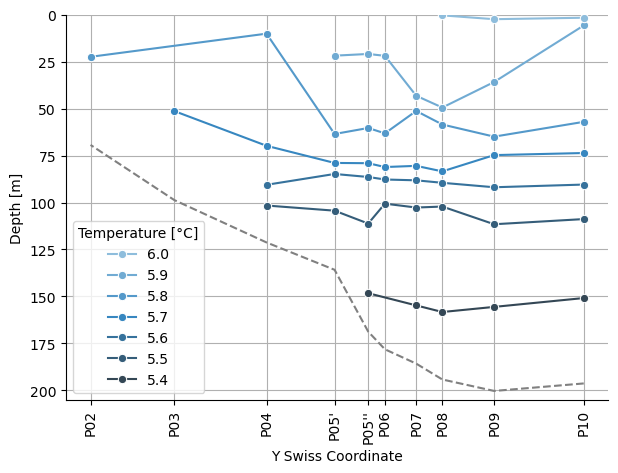

In [38]:
plot_isolines(isotherm_data, 'Temp', t_end='17:00')

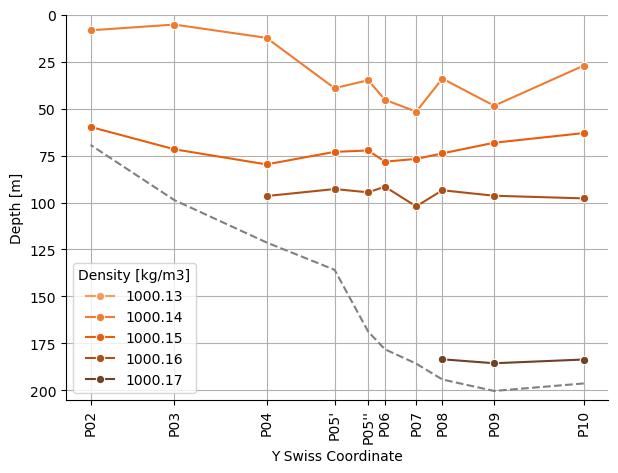

In [39]:
plot_isolines(isopycnal_data, 'rho', t_end='17:00')

#### Anoxic region

In [42]:
def calculate_transect_min_do(dpath_L1):
    # transect minimum
    min_do = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # data quality
        mask = (ds['depth'].notnull()) & (ds[f'DO_mg_qual'] == 0)
        do = ds['DO_mg'][mask]
        min_do.append(do.min().item())

    return min(min_do)


def calculate_anoxia(dpath_L1, err=0.2, oom=True):
    min_do = calculate_transect_min_do(dpath_L1)

    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        mask = (ds['depth'].notnull()) & (ds[f'DO_mg_qual'] == 0)
        depth = ds['depth'][mask]
        do = ds['DO_mg'][mask]

        try:
            idx = np.where(do <= min_do + err)[0][0]
            z = depth[idx].item()
        except IndexError:
            z = np.nan

        data.append({
            'anoxic_z': z,
            'name': name,
            'time': time,
            'xsc': xsc,
            'ysc': ysc,
            'total_depth': total_depth
        })

    return pd.DataFrame(data).sort_values(by='time', ascending=True).reset_index(drop=True)


In [43]:
anoxic_data = calculate_anoxia(dpath_L1)

In [44]:
def plot_anoxia(data, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]

    fig, ax = plt.subplots(figsize=(7, 5))

    sns.lineplot(df, x='ysc', y='anoxic_z', color='limegreen', marker='o', ax=ax)

    md = df.groupby(['name', 'time', 'xsc', 'ysc'])['total_depth'].mean().reset_index()
    sns.lineplot(md, x='ysc', y='total_depth', color='gray', ls='--', ax=ax)

    ax.set_xlabel('Y Swiss Coordinate')
    ax.set_ylabel('Depth [m]')
    ax.set_title('Anoxic Zone')
    ax.set_xticks(md['ysc'], labels=md['name'], rotation=90)
    ax.set_ylim(0, 205)
        
    ax.spines[['right', 'top']].set_visible(False)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.grid(True)
    plt.show()

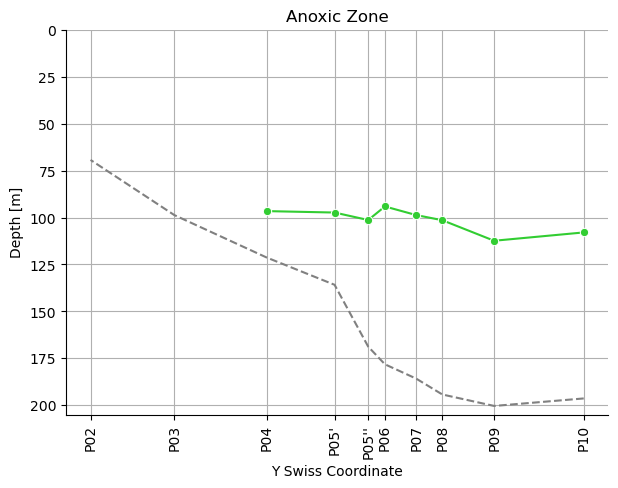

In [46]:
plot_anoxia(anoxic_data, t_end='17:00')